In [3]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_parquet("../data/data_with_meteo.parquet")

df.head()

,stationcode,name,is_installed,capacity,numdocksavailable,numbikesavailable,mechanical,ebike,is_renting,is_returning,duedate,coordonnees_geo,nom_arrondissement_communes,code_insee_commune,temperature_2m,precipitation,rain,snowfall,relative_humidity_2m,is_holiday
0,16107,Benjamin Godard - Victor Hugo,OUI,35.0,30,5,2,3,OUI,OUI,2024-10-21 12:49:53+00:00,"[48.865983, 2.275725]",Paris,75056,20.75,0.0,0.0,0.0,71.68051,1
1,9020,Toudouze - Clauzel,OUI,21.0,18,2,0,2,OUI,OUI,2024-10-21 12:46:01+00:00,"[48.87929591733507, 2.3373600840568547]",Paris,75056,20.75,0.0,0.0,0.0,71.68051,1
2,14111,Cassini - Denfert-Rochereau,OUI,25.0,21,1,1,0,OUI,OUI,2024-10-21 12:47:41+00:00,"[48.837525839067, 2.3360354080796]",Paris,75056,20.75,0.0,0.0,0.0,71.68051,1
3,13007,Le Brun - Gobelins,OUI,48.0,40,4,1,3,OUI,OUI,2024-10-21 12:49:56+00:00,"[48.835092787824, 2.3534681351338]",Paris,75056,20.75,0.0,0.0,0.0,71.68051,1
4,5110,Lacépède - Monge,OUI,23.0,6,17,7,10,OUI,OUI,2024-10-21 12:48:48+00:00,"[48.84389286531899, 2.3519663885235786]",Paris,75056,20.75,0.0,0.0,0.0,71.68051,1


In [5]:
if 'duedate' in df.columns:
    df['duedate'] = pd.to_datetime(df['duedate'])
    df = df.sort_values(by='duedate').reset_index(drop=True)

print("--- FORME DES DONNÉES ---")
print(f"Dimensions : {df.shape}")
print(f"Types :\n{df.dtypes.value_counts()}")

--- FORME DES DONNÉES ---
Dimensions : (177406, 20)
Types :
object                 8
float64                6
int64                  5
datetime64[ns, UTC]    1
Name: count, dtype: int64



--- VALEURS MANQUANTES ---
name                           1
capacity                       1
coordonnees_geo                1
nom_arrondissement_communes    1
code_insee_commune             1
dtype: int64


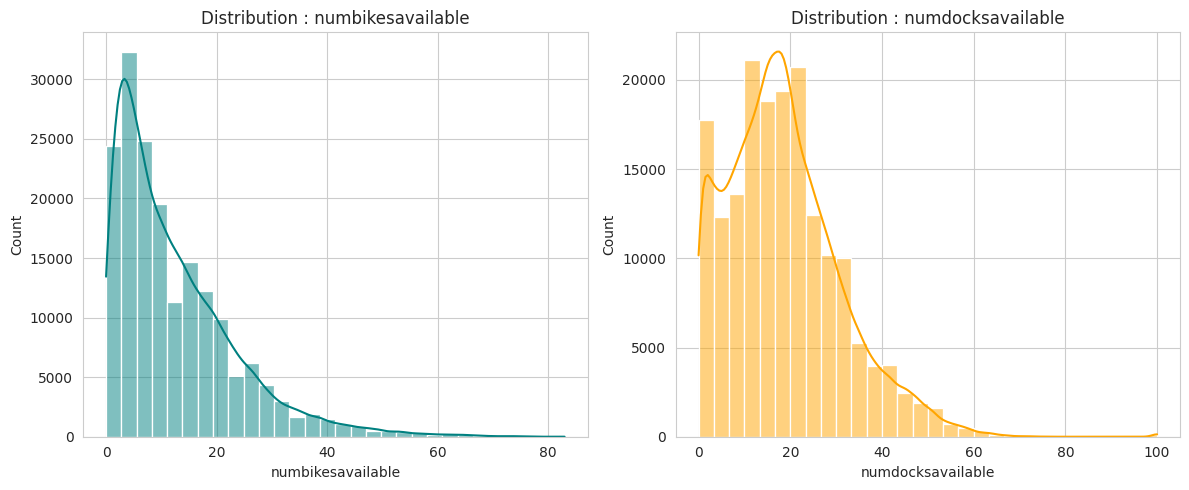

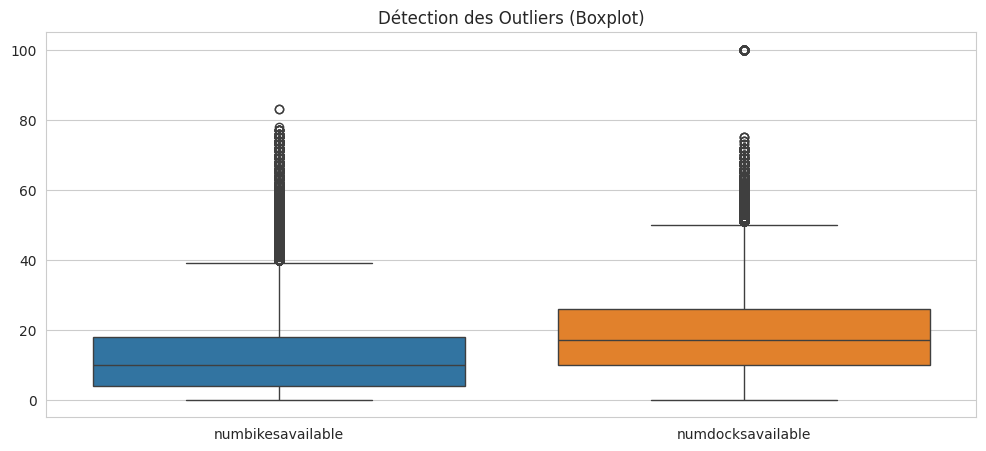

In [7]:
# --- DATA UNDERSTANDING ---

# Identification des cibles
targets = ['numbikesavailable', 'numdocksavailable']

# Analyse des valeurs manquantes
missing = df.isnull().sum()
print("\n--- VALEURS MANQUANTES ---")
print(missing[missing > 0])

# Visualisation des Cibles (Histogrammes)
plt.figure(figsize=(12, 5))
for i, col in enumerate(targets):
    plt.subplot(1, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True, color='teal' if i==0 else 'orange')
    plt.title(f'Distribution : {col}')
plt.tight_layout()
plt.show() #

# Analyse des Outliers (Boxplot)
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[targets])
plt.title("Détection des Outliers (Boxplot)")
plt.show()


Text(0.5, 1.0, 'Correlation')

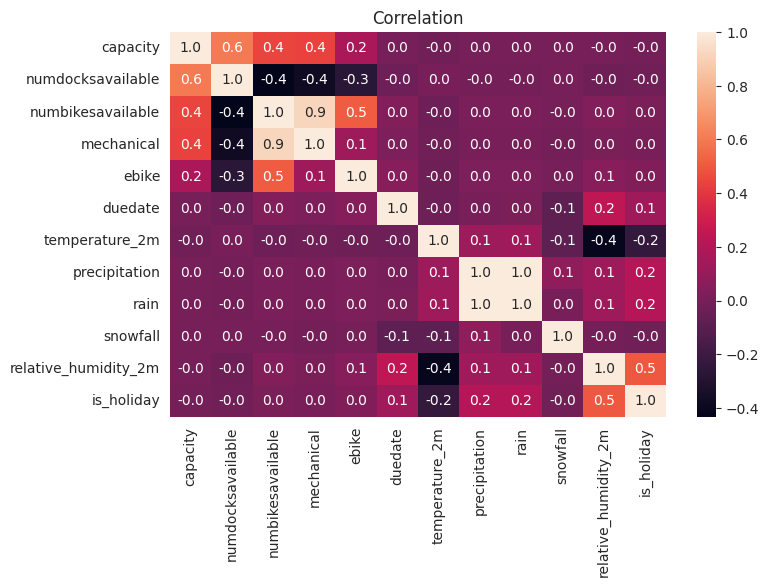

In [8]:
cat_values = df.select_dtypes(['object'])
num_values = df.drop(columns=cat_values.columns)
corr = num_values.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt=".1f")
plt.title("Correlation")

In [9]:
# --- DATA PREPARATION ---

def feature_engineering(data):
    df_fe = data.copy()

    # A. Extraction Temporelle
    df_fe['hour'] = df_fe['duedate'].dt.hour
    df_fe['month'] = df_fe['duedate'].dt.month
    df_fe['dayofweek'] = df_fe['duedate'].dt.dayofweek
    df_fe['is_weekend'] = df_fe['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

    # B. Encodage Cyclique (Respect de la continuité temporelle 23h -> 00h)
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour'] / 24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour'] / 24)
    df_fe['dow_sin'] = np.sin(2 * np.pi * df_fe['dayofweek'] / 7)
    df_fe['dow_cos'] = np.cos(2 * np.pi * df_fe['dayofweek'] / 7)

    # C. Ratios de capacité (Feature métier)
    # On évite la division par zéro
    df_fe['capacity'] = df_fe['capacity'].replace(0, 1)
    df_fe['bikes_ratio'] = df_fe['numbikesavailable'] / df_fe['capacity']
    df_fe['docks_ratio'] = df_fe['numdocksavailable'] / df_fe['capacity']

    return df_fe

print("Application du Feature Engineering...")
df_processed = feature_engineering(df)

Application du Feature Engineering...


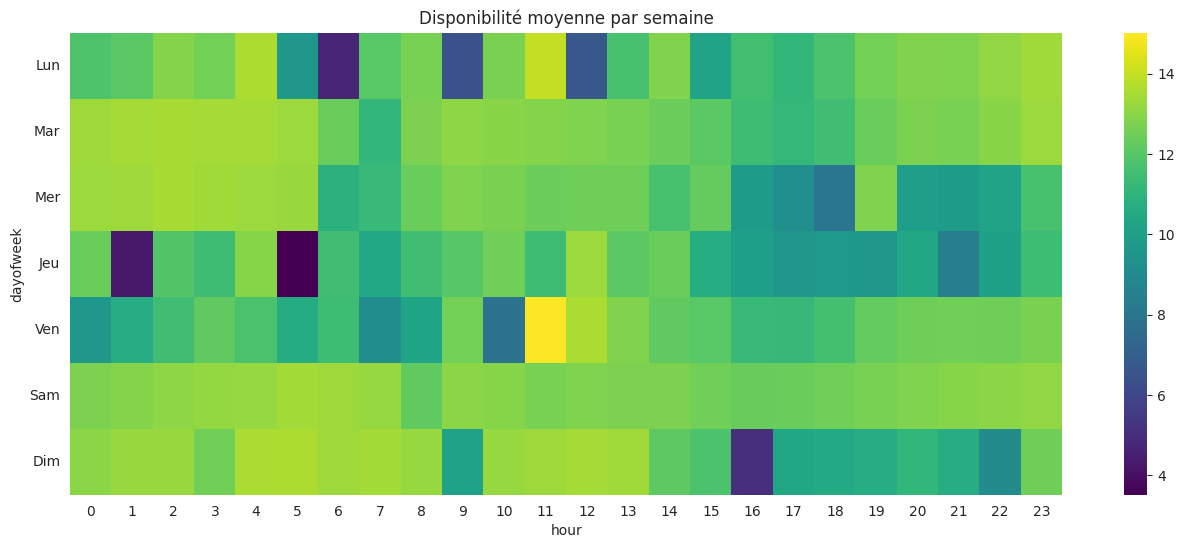

In [10]:
heatmap_data = df_processed.pivot_table(index='dayofweek', columns='hour', values='numbikesavailable', aggfunc='mean')
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title("Disponibilité moyenne par semaine")
plt.yticks(ticks=np.arange(0.5, 7.5), labels=['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'], rotation=0)
plt.show()

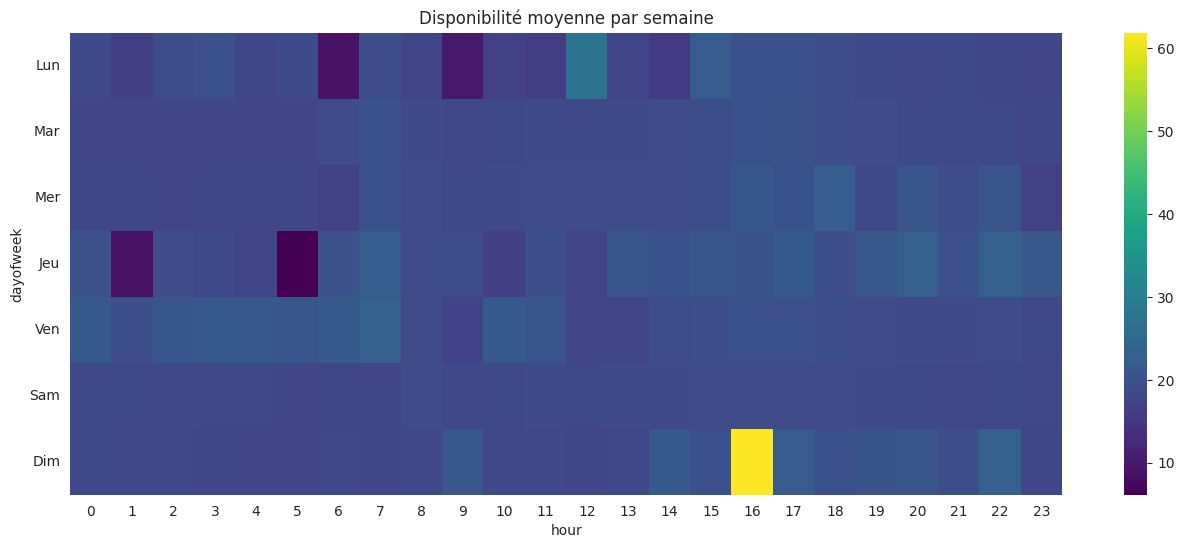

In [11]:
heatmap_data = df_processed.pivot_table(index='dayofweek', columns='hour', values='numdocksavailable', aggfunc='mean')
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title("Disponibilité moyenne par semaine")
plt.yticks(ticks=np.arange(0.5, 7.5), labels=['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'], rotation=0)
plt.show()

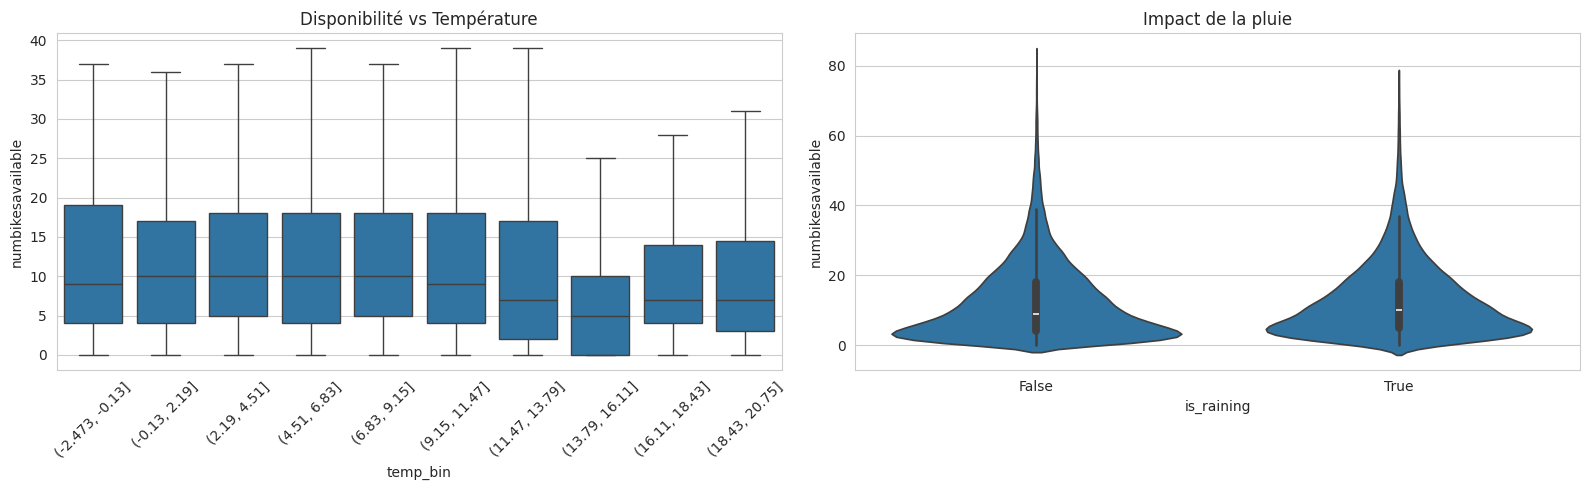

In [12]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
# Binning de la température pour voir des tendances
df['temp_bin'] = pd.cut(df['temperature_2m'], bins=10)
sns.boxplot(data=df, x='temp_bin', y='numbikesavailable', showfliers=False)
plt.xticks(rotation=45)
plt.title("Disponibilité vs Température")

plt.subplot(1, 2, 2)
# Pluie : On compare "Pluie" vs "Pas de pluie"
df['is_raining'] = df['rain'] > 0
sns.violinplot(data=df, x='is_raining', y='numbikesavailable')
plt.title("Impact de la pluie")

plt.tight_layout()

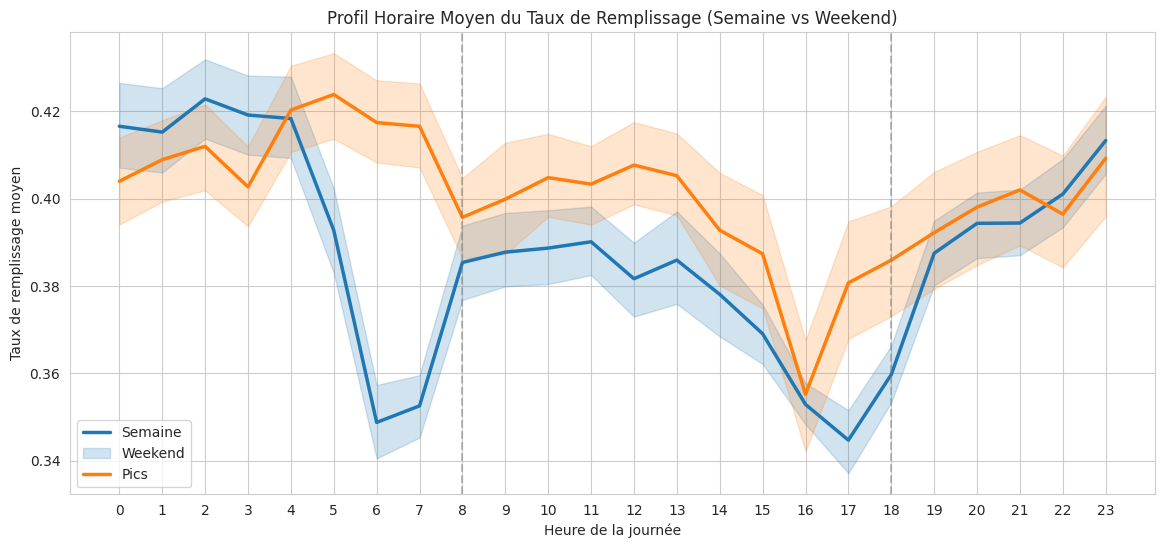

In [13]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_processed, x='hour', y='bikes_ratio', hue='is_weekend',
             palette={False: '#1f77b4', True: '#ff7f0e'}, linewidth=2.5)

plt.title("Profil Horaire Moyen du Taux de Remplissage (Semaine vs Weekend)")
plt.ylabel("Taux de remplissage moyen")
plt.xlabel("Heure de la journée")
plt.xticks(range(0, 24))
plt.axvline(8, color='gray', linestyle='--', alpha=0.5, label='Pointe Matin (8h)')
plt.axvline(18, color='gray', linestyle='--', alpha=0.5, label='Pointe Soir (18h)')
plt.legend(['Semaine', 'Weekend', 'Pics'])
plt.show()

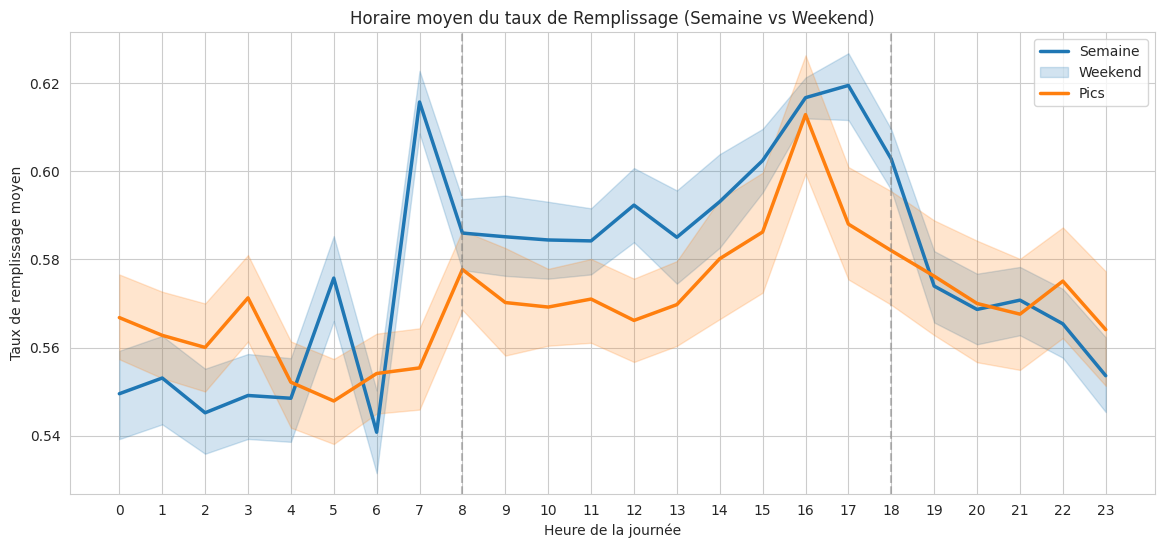

In [14]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_processed, x='hour', y='docks_ratio', hue='is_weekend',
             palette={False: '#1f77b4', True: '#ff7f0e'}, linewidth=2.5)

plt.title("Horaire moyen du taux de Remplissage (Semaine vs Weekend)")
plt.ylabel("Taux de remplissage moyen")
plt.xlabel("Heure de la journée")
plt.xticks(range(0, 24))
plt.axvline(8, color='gray', linestyle='--', alpha=0.5, label='Pointe Matin (8h)')
plt.axvline(18, color='gray', linestyle='--', alpha=0.5, label='Pointe Soir (18h)')
plt.legend(['Semaine', 'Weekend', 'Pics'])
plt.show()

In [16]:
# Identifier et convertir les colonnes de type 'category' contenant des intervalles
for col in df_processed.select_dtypes(include=['category']).columns:
    # On vérifie si la catégorie contient des objets de type Interval
    if df_processed[col].size > 0 and isinstance(df_processed[col].values.categories[0], pd.Interval):
        df_processed[col] = df_processed[col].astype(str)

# 2. Sauvegarder à nouveau
df_processed.to_parquet('../data/cleaned_data.parquet')